In [1]:
import os, json, glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
FIG_DIR    = os.path.join(PROJECT_ROOT, "figures")
REPORT_DIR = os.path.join(PROJECT_ROOT, "reports")
os.makedirs(FIG_DIR, exist_ok=True)

def read_json(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# Metrics JSONs (produced by 03/04 or an ensemble notebook)
rf_metrics  = read_json(os.path.join(REPORT_DIR, "rf_metrics.json"))
xgb_metrics = read_json(os.path.join(REPORT_DIR, "xgb_metrics.json"))
ens_metrics = read_json(os.path.join(REPORT_DIR, "ensemble_metrics.json"))

# SHAP importance CSVs (produced by 05)
def try_read_csv(*paths):
    for p in paths:
        if os.path.exists(p):
            return pd.read_csv(p)
    return None

rf_shap = try_read_csv(
    os.path.join(REPORT_DIR, "rf_shap_importance.csv"),
    os.path.join(REPORT_DIR, "random_forest_shap_importance.csv"),
    os.path.join(REPORT_DIR, "random forest_shap_importance.csv"),
)
xgb_shap = try_read_csv(
    os.path.join(REPORT_DIR, "xgb_shap_importance.csv"),
    os.path.join(REPORT_DIR, "xgboost_shap_importance.csv"),
)

rf_metrics, xgb_metrics, ens_metrics, rf_shap, xgb_shap


({'accuracy': 0.7175141242937854,
  'macro': {'precision': 0.665178248988401,
   'recall': 0.659944002403867,
   'f1': 0.6603740938075972},
  'micro': {'precision': 0.7175141242937854,
   'recall': 0.7175141242937854,
   'f1': 0.7175141242937854},
  'weighted': {'precision': 0.731814943496479,
   'recall': 0.7175141242937854,
   'f1': 0.7230259840059764},
  'per_class': {'Dropout': {'precision': 0.7951807228915663,
    'recall': 0.6971830985915493,
    'f1': 0.7429643527204502,
    'support': 284},
   'Graduate': {'precision': 0.38421052631578945,
    'recall': 0.4591194968553459,
    'f1': 0.4183381088825215,
    'support': 159},
   'Enrolled': {'precision': 0.8161434977578476,
    'recall': 0.8235294117647058,
    'f1': 0.8198198198198198,
    'support': 442}},
  'classification_report': {'Dropout': {'precision': 0.7951807228915663,
    'recall': 0.6971830985915493,
    'f1-score': 0.7429643527204502,
    'support': 284.0},
   'Graduate': {'precision': 0.38421052631578945,
    'recal

In [2]:
def row_from(m, name):
    if not m: 
        return None
    return {
        "Model": name,
        "Accuracy":      float(m.get("accuracy")),
        "Precision (macro)": float(m.get("macro",{}).get("precision")),
        "Recall (macro)":    float(m.get("macro",{}).get("recall")),
        "F1 (macro)":        float(m.get("macro",{}).get("f1")),
    }

rows = []
for name, blob in [("Random Forest", rf_metrics),
                   ("XGBoost", xgb_metrics),
                   ("Ensemble", ens_metrics)]:
    r = row_from(blob, name)
    if r: rows.append(r)

metrics_df = pd.DataFrame(rows)
display(metrics_df)


,Model,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,Random Forest,0.717514,0.665178,0.659944,0.660374
1,XGBoost,0.732203,0.676787,0.677215,0.675539
2,Ensemble,0.749153,0.685609,0.670491,0.675914


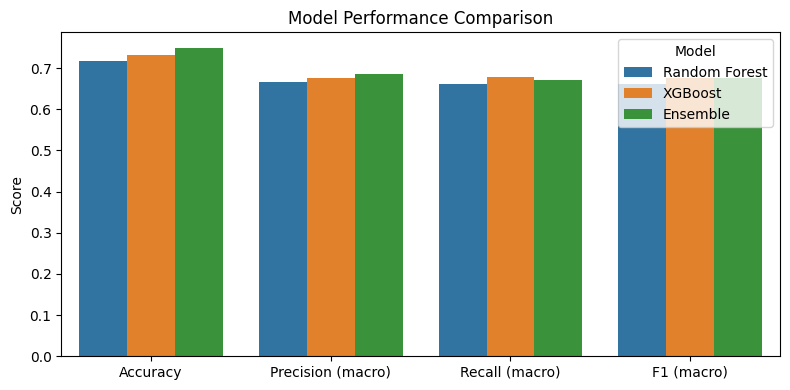

In [3]:
if metrics_df.empty:
    print("No metrics found.")
else:
    long = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    plt.figure(figsize=(8,4))
    sns.barplot(data=long, x="Metric", y="Score", hue="Model")
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "model_comparison.png"), dpi=150)
    plt.show()


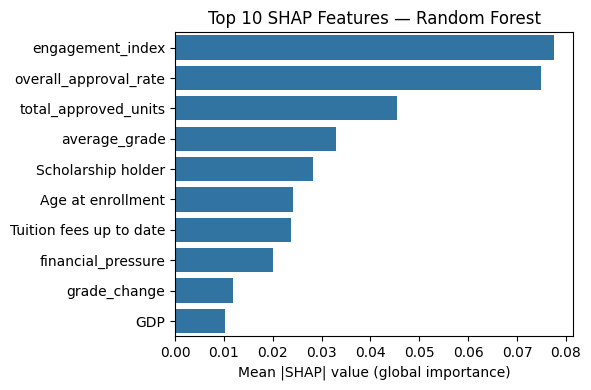

In [4]:
if rf_shap is None or not {"feature","mean_abs_shap"}.issubset(rf_shap.columns):
    print("RF SHAP importance not found with expected columns.")
else:
    top_rf = rf_shap.sort_values("mean_abs_shap", ascending=False).head(10)
    plt.figure(figsize=(6,4))
    sns.barplot(data=top_rf, x="mean_abs_shap", y="feature")
    plt.title("Top 10 SHAP Features — Random Forest")
    plt.xlabel("Mean |SHAP| value (global importance)")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "rf_top_shap_features.png"), dpi=150)
    plt.show()


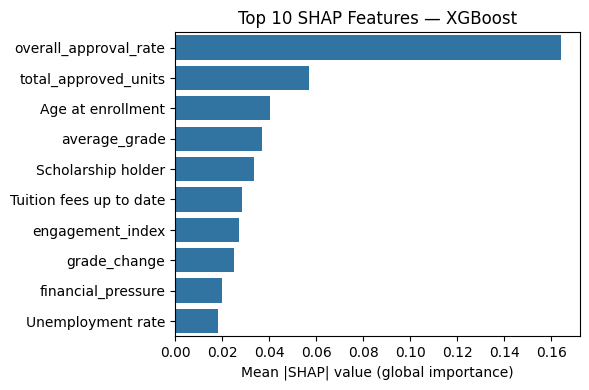

In [5]:
if xgb_shap is None or not {"feature","mean_abs_shap"}.issubset(xgb_shap.columns):
    print("XGB SHAP importance not found with expected columns.")
else:
    top_xgb = xgb_shap.sort_values("mean_abs_shap", ascending=False).head(10)
    plt.figure(figsize=(6,4))
    sns.barplot(data=top_xgb, x="mean_abs_shap", y="feature")
    plt.title("Top 10 SHAP Features — XGBoost")
    plt.xlabel("Mean |SHAP| value (global importance)")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "xgb_top_shap_features.png"), dpi=150)
    plt.show()


In [6]:
def fmt_line(model_name):
    row = metrics_df.loc[metrics_df["Model"]==model_name]
    if row.empty: 
        return []
    r = row.iloc[0]
    return [
        f"**{model_name}**",
        f"- Accuracy: {r['Accuracy']:.3f}",
        f"- Precision (macro): {r['Precision (macro)']:.3f}",
        f"- Recall (macro): {r['Recall (macro)']:.3f}",
        f"- F1 (macro): {r['F1 (macro)']:.3f}",
        ""
    ]

def top_list(df, k=5):
    return df.sort_values("mean_abs_shap", ascending=False).head(k)["feature"].tolist()

lines = ["# Final Results Summary", ""]
lines += fmt_line("Random Forest")
lines += fmt_line("XGBoost")
lines += fmt_line("Ensemble")

if rf_shap is not None and {"feature","mean_abs_shap"}.issubset(rf_shap.columns):
    rf_top = top_list(rf_shap, 5)
    lines += ["**Top Predictors (SHAP) — Random Forest:**"] + [f"{i+1}. {f}" for i,f in enumerate(rf_top)] + [""]

if xgb_shap is not None and {"feature","mean_abs_shap"}.issubset(xgb_shap.columns):
    xgb_top = top_list(xgb_shap, 5)
    lines += ["**Top Predictors (SHAP) — XGBoost:**"] + [f"{i+1}. {f}" for i,f in enumerate(xgb_top)] + [""]

# Keep a high-level interpretation
lines += ["**Interpretation:** Academic performance and tuition compliance dominate student outcome prediction."]

out_path = os.path.join(REPORT_DIR, "final_summary.md")
with open(out_path, "w") as f:
    f.write("\n".join(lines).strip())

print("Saved:", out_path)


Saved: /home/glinux/Projects/Skole/AnvendtData/reports/final_summary.md
